# Conservative Regridding

This tutorial will explain to you the concept of conservative regridding and 
how emiproc uses geopandas to perform this operation.

This tutorial is there solely for educational purposes.
If you use emiproc, you can use the
[`remap_inventory`](https://emiproc.readthedocs.io/en/master/api/operators.html#emiproc.regrid.remap_inventory)
function to perform conservative regridding on your inventories.

In [1]:
import geopandas as gpd
from emiproc.grids import RegularGrid
from shapely.geometry import Polygon

In [2]:


# Create some toy data 
grid = RegularGrid(nx=3, ny=2, dx=1, dy=1, xmin=0, ymin=0, crs=None)
grid_serie = grid.gdf.geometry
grid_serie.explore()


This is a regular grid with 6 squared cells.
We now want to create another grid in this to see how we can to the remapping.

In [3]:
# We 
triangle = Polygon([(-1, 1), (1.5, 0), (1.5, 2)])
# We put another polygon on the side 
polygon = Polygon([(1.5, 2 ), (1.5, 0), (3, 0), (4, 1), (3, 2)])
serie = gpd.GeoSeries([triangle, polygon])
serie.explore()

## Spatial join 

The first step is to genereate find which shapes will intersect shapes from the other grid.

This can be performed using the `geopandas.overlay` function.
It supports only geodataframes.

In [4]:
grid_gdf = grid.gdf
grid_gdf['source_index'] = grid_gdf.index

gdf_out = gpd.GeoDataFrame(geometry=serie)
gdf_out['target_index'] = gdf_out.index

gdf_overlayed = gpd.overlay(grid_gdf, gdf_out, how='intersection')
gdf_overlayed

,source_index,target_index,geometry
0,0,0,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1...."
1,1,0,"POLYGON ((0.00000 1.40000, 1.00000 1.80000, 1...."
2,2,0,"POLYGON ((1.00000 1.00000, 1.50000 1.00000, 1...."
3,2,1,"POLYGON ((2.00000 1.00000, 2.00000 0.00000, 1...."
4,3,0,"POLYGON ((1.00000 1.80000, 1.50000 2.00000, 1...."
5,3,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
6,4,1,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3...."
7,5,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3...."


Now we have the intersections between the two grids. Each line will be a mapping between a cell in the source grid and a cell in the target grid.

Cell index of the input grid is `source_index`. The column `target_index` is the index of the cell in the target grid.


<Axes: >

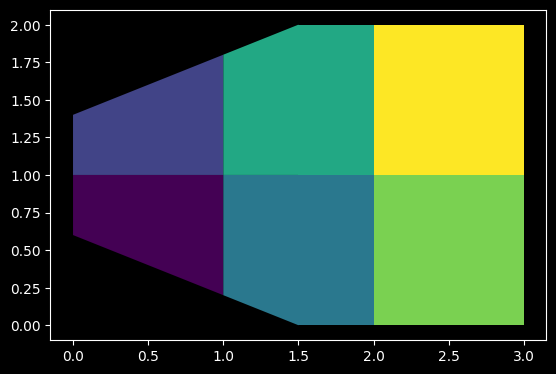

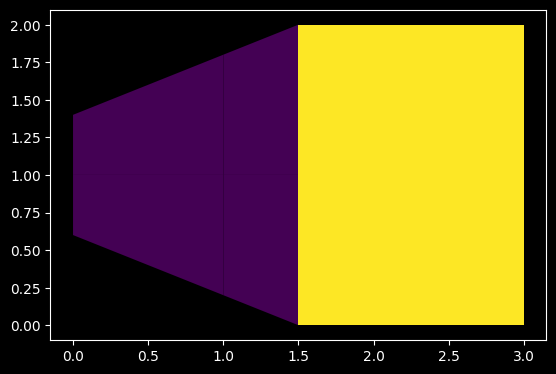

In [5]:
gdf_overlayed.plot('source_index')
gdf_overlayed.plot('target_index')

## Weight calculation

The next step is to calculate the weights for each intersection.

For that we apply a method that compares the area of the polygon that falls in the target polygon.

To calculate the area of each intersection, we need to create the intersection polygon.

In [6]:
gdf_overlayed['area_overlay'] = gdf_overlayed.area
gdf_overlayed['area_source'] = gdf_overlayed['source_index'].map(grid_gdf.area)
gdf_overlayed['weights'] = gdf_overlayed['area_overlay'] / gdf_overlayed['area_source']
gdf_overlayed

,source_index,target_index,geometry,area_overlay,area_source,weights
0,0,0,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.60,1.0,0.60
1,1,0,"POLYGON ((0.00000 1.40000, 1.00000 1.80000, 1....",0.60,1.0,0.60
2,2,0,"POLYGON ((1.00000 1.00000, 1.50000 1.00000, 1....",0.45,1.0,0.45
3,2,1,"POLYGON ((2.00000 1.00000, 2.00000 0.00000, 1....",0.50,1.0,0.50
4,3,0,"POLYGON ((1.00000 1.80000, 1.50000 2.00000, 1....",0.45,1.0,0.45
5,3,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1....",0.50,1.0,0.50
6,4,1,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",1.00,1.0,1.00
7,5,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",1.00,1.0,1.00


The weight express how much of the source cell is in the target cell.

If you sum the weights for all intersections of a source cell, you will get 1.

In [7]:
gdf_overlayed.explore('weights')

## Remapping data

The good thing of working with weights, is that you need simply to calculate them once and then you can apply them to any data.

For this example, we will assign some values to the source grid and remap them to the target grid.

In [8]:
# Assign values to the grid
import numpy as np

grid_gdf['value1'] = 1

grid_gdf

,geometry,source_index,value1
0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",0,1
1,"POLYGON ((0.00000 1.00000, 0.00000 2.00000, 1....",1,1
2,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",2,1
3,"POLYGON ((1.00000 1.00000, 1.00000 2.00000, 2....",3,1
4,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",4,1
5,"POLYGON ((2.00000 1.00000, 2.00000 2.00000, 3....",5,1


In [9]:
col = 'value1'
# Expand the input data to multiply it with the weights 
gdf_overlayed[col] = grid_gdf.loc[gdf_overlayed['source_index'], col].values
gdf_overlayed



,source_index,target_index,geometry,area_overlay,area_source,weights,value1
0,0,0,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.60,1.0,0.60,1
1,1,0,"POLYGON ((0.00000 1.40000, 1.00000 1.80000, 1....",0.60,1.0,0.60,1
2,2,0,"POLYGON ((1.00000 1.00000, 1.50000 1.00000, 1....",0.45,1.0,0.45,1
3,2,1,"POLYGON ((2.00000 1.00000, 2.00000 0.00000, 1....",0.50,1.0,0.50,1
4,3,0,"POLYGON ((1.00000 1.80000, 1.50000 2.00000, 1....",0.45,1.0,0.45,1
5,3,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1....",0.50,1.0,0.50,1
6,4,1,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",1.00,1.0,1.00,1
7,5,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",1.00,1.0,1.00,1


In [10]:
# Multiply the values by the weights
gdf_overlayed[col] *= gdf_overlayed['weights'] 
gdf_overlayed

,source_index,target_index,geometry,area_overlay,area_source,weights,value1
0,0,0,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.60,1.0,0.60,0.60
1,1,0,"POLYGON ((0.00000 1.40000, 1.00000 1.80000, 1....",0.60,1.0,0.60,0.60
2,2,0,"POLYGON ((1.00000 1.00000, 1.50000 1.00000, 1....",0.45,1.0,0.45,0.45
3,2,1,"POLYGON ((2.00000 1.00000, 2.00000 0.00000, 1....",0.50,1.0,0.50,0.50
4,3,0,"POLYGON ((1.00000 1.80000, 1.50000 2.00000, 1....",0.45,1.0,0.45,0.45
5,3,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1....",0.50,1.0,0.50,0.50
6,4,1,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",1.00,1.0,1.00,1.00
7,5,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",1.00,1.0,1.00,1.00


In [11]:
# Sum the values belonging to the same target index
gdf_out[col] = gdf_overlayed.groupby('target_index')[col].sum().values
gdf_out

,geometry,target_index,value1
0,"POLYGON ((-1.00000 1.00000, 1.50000 0.00000, 1...",0,2.1
1,"POLYGON ((1.50000 2.00000, 1.50000 0.00000, 3....",1,3.0


Now we can try to have other values and see the results.

In [12]:
grid_gdf['value2'] = np.arange(len(grid_gdf))
grid_gdf['value3'] = np.arange(len(grid_gdf))**2

for col in ['value2', 'value3']:
    gdf_overlayed[col] = grid_gdf.loc[gdf_overlayed['source_index'], col].values
    gdf_overlayed[col] *= gdf_overlayed['weights'] 
    gdf_out[col] = gdf_overlayed.groupby('target_index')[col].sum().values

In [13]:
gdf_out

,geometry,target_index,value1,value2,value3
0,"POLYGON ((-1.00000 1.00000, 1.50000 0.00000, 1...",0,2.1,2.85,6.45
1,"POLYGON ((1.50000 2.00000, 1.50000 0.00000, 3....",1,3.0,11.50,47.50
